# UNet Apple Segmentation

### This project shows my own implementation of the UNet Image Segmentation model with the purpose of segmenting apples in an orchard environment. The dataset used was the *detection* subest of the [MinneApple Dataset](https://rsn.umn.edu/projects/orchard-monitoring/minneapple). 

In [76]:
#Unzip
# !unzip "/content/drive/MyDrive/Datasets/MinneApple/test_data.zip" -d "/content/drive/MyDrive/Datasets/MinneApple/test_data"

In [77]:
# !tar -xzvf "/content/drive/MyDrive/Datasets/MinneApple/detection.tar.gz" -C "/content/drive/MyDrive/Datasets/MinneApple/detection"     #[run this cell to extract tar.gz files]

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os 
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU


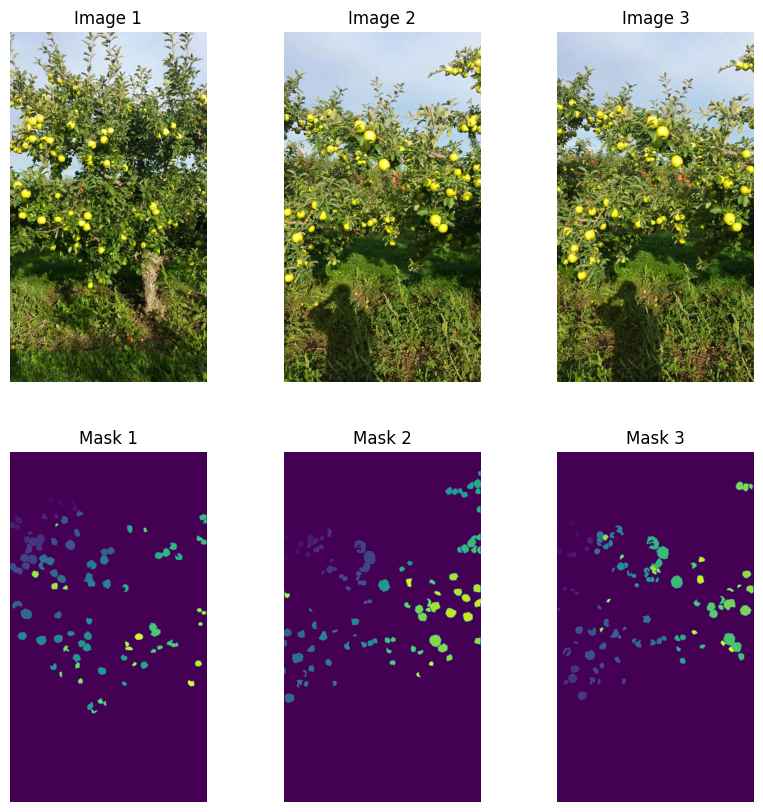

In [79]:
# Show some examples of the training images and corresponding image masks

# Load images and masks
image1 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/images/20150919_174151_image1.png")
image2 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/images/20150919_174151_image101.png")
image3 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/images/20150919_174151_image106.png")
mask1 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks/20150919_174151_image1.png")
mask2 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks/20150919_174151_image101.png")
mask3 = Image.open("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks/20150919_174151_image106.png")

# Create grid
fig, axes, = plt.subplots(nrows=2, ncols=3, figsize = (10, 10))

# Shows images and masks
axes[0, 0].imshow(image1)
axes[0, 0].set_title('Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(image2)
axes[0, 1].set_title('Image 2')
axes[0, 1].axis('off')

axes[0, 2].imshow(image3)
axes[0, 2].set_title('Image 3')
axes[0, 2].axis('off')

axes[1, 0].imshow(mask1)
axes[1, 0].set_title('Mask 1')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask2)
axes[1, 1].set_title('Mask 2')
axes[1, 1].axis('off')

axes[1, 2].imshow(mask3)
axes[1, 2].set_title('Mask 3')
axes[1, 2].axis('off')

# Display the grid
plt.show()

In [80]:
# Check the lengths of the training set and the masks
train_image_length = len(os.listdir("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/images"))
train_mask_length = len(os.listdir("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks"))

print(f"There are {train_image_length} images in the dataset with {train_mask_length} masks")

There are 670 images in the dataset with 670 masks


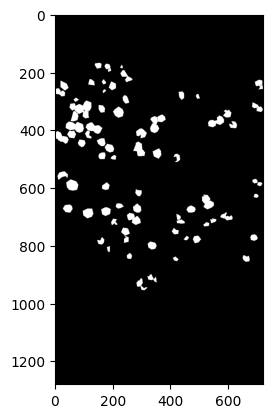

In [81]:
# Threshold the image annotations and then convert to grayscale

img = cv.imread("/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks/20150919_174151_image1.png")
_, thresholded_img = cv.threshold(img, 1, 255, cv.THRESH_BINARY)
#gray_image = cv.cvtColor(thresholded_img, cv.COLOR_BGR2GRAY)

plt.imshow(thresholded_img)
plt.show()


In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_grayscale_mask(mask):
    # Load the grayscale mask image
    #mask = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

    plt.imshow(mask)
    plt.show()


    # Calculate the percentage of white and black pixels
    total_pixels = mask.size
    white_pixels = np.sum(mask == 255)
    black_pixels = np.sum(mask == 0)

    white_percentage = (white_pixels / total_pixels) * 100
    black_percentage = (black_pixels / total_pixels) * 100

    print(f"White pixels: {white_pixels} ({white_percentage:.2f}%)")
    print(f"Black pixels: {black_pixels} ({black_percentage:.2f}%)")

    return white_percentage, black_percentage


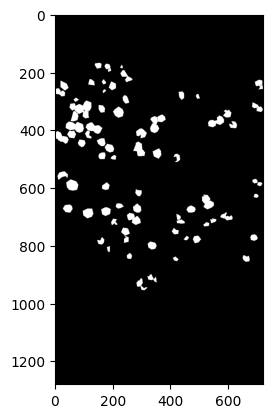

White pixels: 127113 (4.60%)
Black pixels: 2637687 (95.40%)


(4.597547743055555, 95.40245225694444)

In [113]:
analyze_grayscale_mask(thresholded_img)

In [84]:
# Function to create the binary mask directly from the data generators

def create_binary_mask(mask):
    _, thresholded_mask = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)
    thresholded_mask = thresholded_mask.astype(np.uint8)  # convert to integer values

    return thresholded_mask



In [85]:
# Directory paths

image_dir = "/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/images"
mask_dir = "/content/drive/MyDrive/Datasets/MinneApple/detection/detection/train/masks"

image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

In [86]:
# Create a pandas dataframe to handle the images and masks
image_filenames.sort() # Ensure that the folders are in the same order
mask_filenames.sort()
data = pd.DataFrame({'image': image_filenames, 'mask':  mask_filenames})


In [87]:
# Split the dataset into training and val/test sets. 
train_data, val_test_data  = train_test_split(data, test_size=0.3, random_state = 42)

# Split val/test 
val_data, test_data  = train_test_split(val_test_data, test_size=0.3, random_state = 42)


In [98]:
# Create datagenerators for images and masks

image_datagen = ImageDataGenerator(rescale = 1.0/255.0)

# the mask datagen first passes the maskes through the function to remove the segment shading

def convert_to_float32(mask):
    return mask.astype(np.float32)

mask_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  preprocessing_function=lambda x: convert_to_float32(create_binary_mask(x)))

In [99]:
seed = 1

# Training and validation image generators

train_image_generator = image_datagen.flow_from_dataframe(train_data,
                                                          directory = image_dir,
                                                          x_col = 'image',
                                                          y_col = None,
                                                          target_size = (256, 256),
                                                          batch_size = 32,
                                                          class_mode = None,
                                                          seed = seed 
                                                          )

train_mask_generator = mask_datagen.flow_from_dataframe(train_data,
                                                        directory = mask_dir,
                                                        x_col = 'mask',
                                                        y_col = None,
                                                        target_size = (256, 256),
                                                        batch_size = 32,
                                                        class_mode = None,
                                                        seed = seed 
                                                        )

val_image_generator = image_datagen.flow_from_dataframe(val_data,
                                                        directory = image_dir,
                                                        x_col = 'image',
                                                        y_col = None,
                                                        target_size = (256, 256),
                                                        batch_size = 32,
                                                        class_mode = None,
                                                        seed = seed 
                                                        )

val_mask_generator = mask_datagen.flow_from_dataframe( val_data,
                                                        directory = mask_dir,
                                                        x_col = 'mask',
                                                        y_col = None,
                                                        target_size = (256, 256),
                                                        batch_size = 32,
                                                        class_mode = None,
                                                        seed = seed 
                                                        )


Found 469 validated image filenames.
Found 469 validated image filenames.
Found 140 validated image filenames.
Found 140 validated image filenames.


In [100]:
# Combine the image and mask generators

train_generator = zip(train_image_generator, train_mask_generator)

val_generator = zip(val_image_generator, val_mask_generator)

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model

# UNet architecture -> Next time make seperate functions for encoder/bottleneck/decoder

def unet(input_size=(256, 256, 3)):
    inputs = tf.keras.Input(input_size)

    # Encoder  - > Image gets downsampled to the bottle neck to detect features
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    # Decoder  -> Upsamples the output to reconstruct the mask
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)  # Skip layer -> transfers info directly from encoder for localisation and refinement
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)  # Skip layer
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)  # Skip layer
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)  # Skip layer
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model


In [102]:
def dice_loss(y_true, y_pred, smooth=1):    # UNUSED
    y_true = tf.expand_dims(y_true, axis=-1)  # Add a channel dimension to y_true
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    dice_coeff = (2. * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coeff



In [4]:
from keras.backend import binary_crossentropy
import tensorflow as tf
from tensorflow.keras import backend as K

# Accuracy is not a good metric in this situation because of the binary classification and
# because the background >> the apples.

def iou(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())


# Compile the model with the custom IoU metric
model = unet(input_size=(256, 256, 3))
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=[iou])



In [5]:
# The model summary shows the image size converging down the encoder then increasing as 
# it gets upsampled in the decoder. 
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [106]:
# A lot of problems training as the model kept converging to a IoU of 0 but with
# a really low loss and a high accuracy. With tweaks and more training the IoU rebounded
history = model.fit(train_generator,
                    steps_per_epoch=len(train_image_generator),
                    epochs=10, 
                    validation_data=val_generator,
                    validation_steps=len(val_image_generator))

Epoch 1/10
15/15 [==============================] - 53s 3s/step - loss: 4.2166 - iou: 0.0057 - val_loss: 0.1612 - val_iou: 0.0000e+00
Epoch 2/10
15/15 [==============================] - 35s 2s/step - loss: 0.1476 - iou: 0.0000e+00 - val_loss: 0.1254 - val_iou: 0.0000e+00
Epoch 3/10
15/15 [==============================] - 39s 3s/step - loss: 0.1156 - iou: 0.0000e+00 - val_loss: 0.1044 - val_iou: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 35s 2s/step - loss: 0.0769 - iou: 0.1372 - val_loss: 0.0650 - val_iou: 0.4352
Epoch 5/10
15/15 [==============================] - 34s 2s/step - loss: 0.0605 - iou: 0.5532 - val_loss: 0.0597 - val_iou: 0.4464
Epoch 6/10
15/15 [==============================] - 35s 2s/step - loss: 0.0561 - iou: 0.6537 - val_loss: 0.0613 - val_iou: 0.7977
Epoch 7/10
15/15 [==============================] - 35s 2s/step - loss: 0.0522 - iou: 0.6687 - val_loss: 0.0497 - val_iou: 0.7408
Epoch 8/10
15/15 [==============================] - 39s 3s/step - loss

In [107]:
# Create a test generator
test_image_generator = image_datagen.flow_from_dataframe(test_data,
                                                          directory = image_dir,
                                                          x_col = 'image',
                                                          y_col = None,
                                                          target_size = (256, 256),
                                                          batch_size = 32,
                                                          class_mode = None,
                                                          seed = seed 
                                                          )

test_mask_generator = mask_datagen.flow_from_dataframe(test_data,
                                                        directory = mask_dir,
                                                        x_col = 'mask',
                                                        y_col = None,
                                                        target_size = (256, 256),
                                                        batch_size = 32,
                                                        class_mode = None,
                                                        seed = seed 
                                                        )

Found 61 validated image filenames.
Found 61 validated image filenames.


In [108]:
# zip test _ generators
test_generator = zip(test_image_generator, test_mask_generator)

In [109]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_image_generator))

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")#", Test IoU: {test_iou}")

2/2 [==============================] - 16s 15s/step - loss: 0.0434 - iou: 0.8966
Test Loss: 0.04338564723730087, Test Accuracy: 0.8966105580329895


1/1 [==============================] - 0s 67ms/step


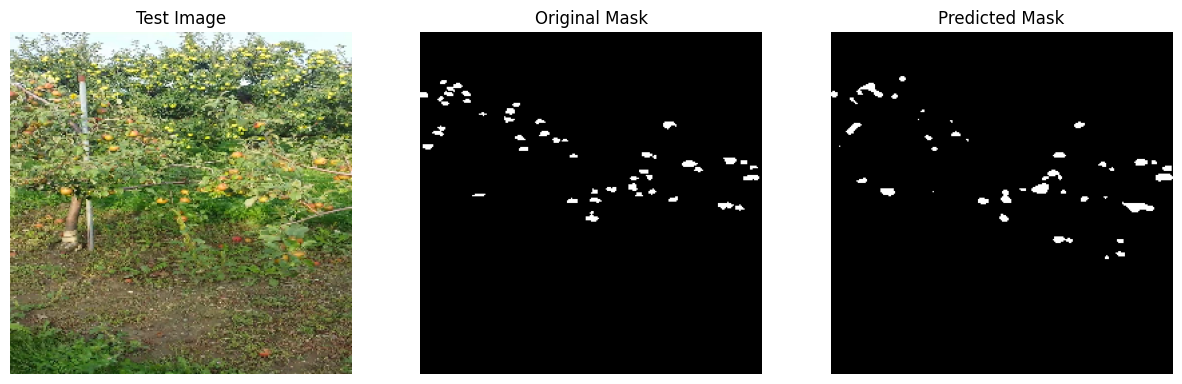

1/1 [==============================] - 0s 33ms/step


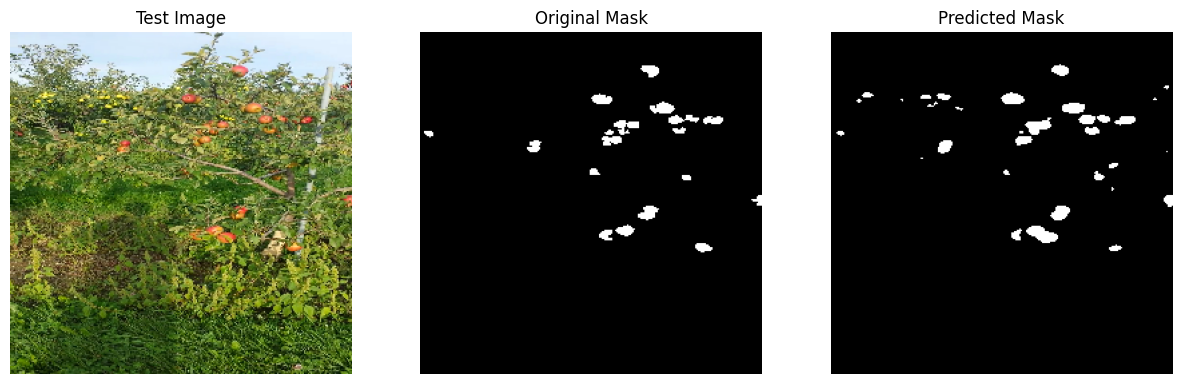

1/1 [==============================] - 0s 49ms/step


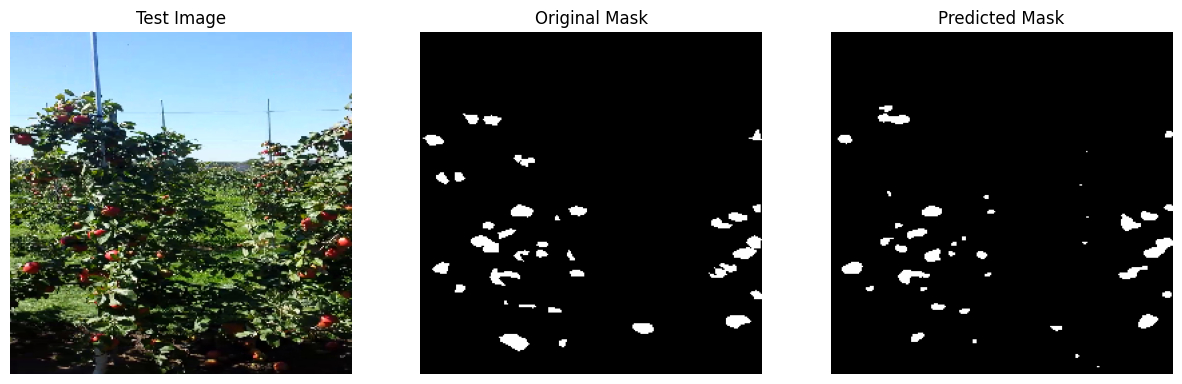

1/1 [==============================] - 0s 34ms/step


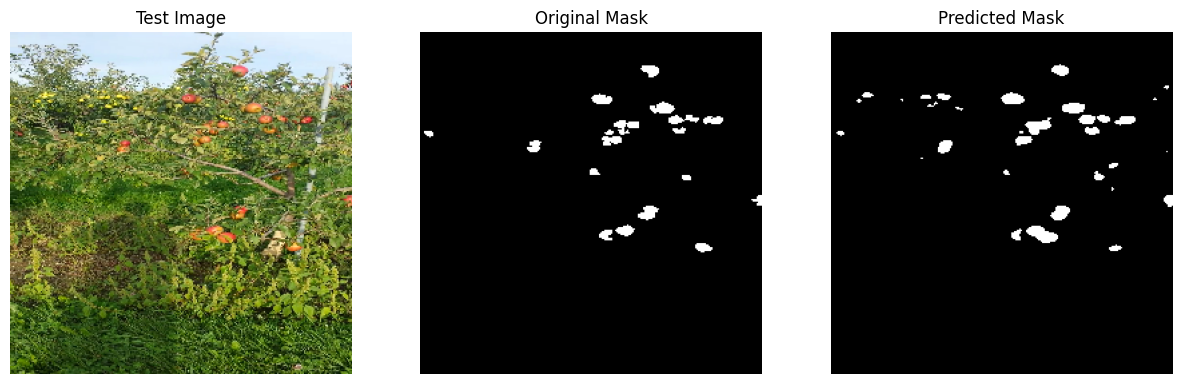

1/1 [==============================] - 0s 63ms/step


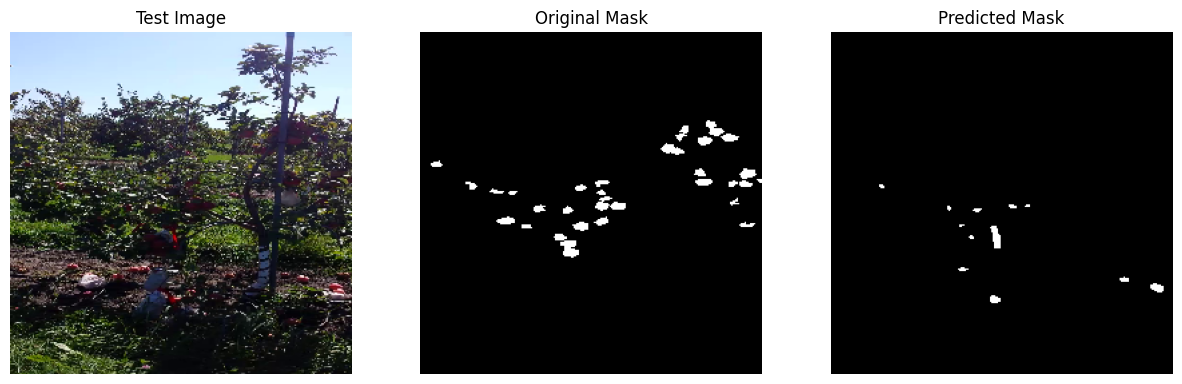

In [111]:
# Loop through a few test images, generate predictions, and visualize results
for i in range(5):  
    test_image, original_mask = next(test_generator)

    # Generate prediction
    predicted_mask = model.predict(test_image)
    predicted_mask = (predicted_mask[0] > 0.5).astype(np.uint8) * 255

    # Preprocess original mask
    original_mask = (original_mask[0] > 0.5).astype(np.uint8) * 255

    # Visualize the results
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(test_image[0])
    ax1.set_title("Test Image")
    ax1.axis("off")

    ax2.imshow(original_mask, cmap="gray")
    ax2.set_title("Original Mask")
    ax2.axis("off")

    ax3.imshow(predicted_mask, cmap="gray")
    ax3.set_title("Predicted Mask")
    ax3.axis("off")

    plt.show()
